In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score
from imblearn.over_sampling import SMOTE


In [2]:
chunksize = 100000
chunks = pd.read_csv("data/processed_data.csv", chunksize=chunksize)

# Combine processed chunks into a single DataFrame
processed_chunks = []
for chunk in chunks:
    processed_chunks.append(chunk)
processed_data = pd.concat(processed_chunks, ignore_index=True)


In [3]:
# Use the same features and target as before
# features = [
#     'SYN Flag Count', 'ACK Flag Count', 'SYN/ACK_Ratio',
#     'Half_Open_Connections', 'Source_IP_Entropy', 'Destination Port'
# ]
# X = processed_data[features]
# label_encoder = LabelEncoder()
# processed_data['Label'] = label_encoder.fit_transform(processed_data['Label'])
# Y = processed_data['Label']

In [4]:
features = list(processed_data.drop(columns=["Label_cleaned"]).columns)

# Shuffle the data
processed_data = processed_data.sample(frac=1, random_state=217)

# Calculate split sizes
nb_train = int(np.floor(0.6 * len(processed_data)))
nb_temp = len(processed_data) - nb_train
nb_val = int(np.floor(0.5 * nb_temp))
nb_test = nb_temp - nb_val

# Split the data
X_train = processed_data[features][:nb_train]
Y_train = processed_data["Label_cleaned"][:nb_train].values

X_temp = processed_data[features][nb_train:]
y_temp = processed_data["Label_cleaned"][nb_train:].values

X_val = X_temp[:nb_val]
Y_val = y_temp[:nb_val]

X_test = X_temp[nb_val:]
Y_test = y_temp[nb_val:]


In [5]:
processed_data.head
processed_data.info


<bound method DataFrame.info of       Flow Duration  Total Fwd Packets  Total Backward Packets  \
1812        8048903                  5                       0   
719               4                  2                       0   
3233       12128926                 11                      12   
3235       71536277                  8                       5   
2046        5626556                  5                       2   
...             ...                ...                     ...   
1045       72154925                  8                       6   
342        62867219                  2                       2   
2441       72101717                  8                       4   
572          865364                  3                       4   
658        71432970                  9                       6   

      Total Length of Fwd Packets  Total Length of Bwd Packets  \
1812                           30                            0   
719                            12          

In [6]:
from imblearn.over_sampling import SMOTE

# # Apply SMOTE for class balancing
# smote = SMOTE(random_state=42)
# X_resampled, Y_resampled = smote.fit_resample(X, Y)

# # Check the new class distribution
# sns.countplot(x=Y_resampled)
# plt.title('Class Distribution After SMOTE')
# plt.xlabel('Class')
# plt.ylabel('Count')
# plt.show()

In [7]:
# # First split: Train (60%) and Temporary (40%)
# X_train, X_temp, Y_train, Y_temp = train_test_split(X_resampled, Y_resampled, test_size=0.4, random_state=42)

# # Second split: Validation (20%) and Test (20%) from Temporary (40%)
# X_validate, X_test, Y_validate, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

inf_locations = np.isinf(processed_data)
print(inf_locations)



      Flow Duration  Total Fwd Packets  Total Backward Packets  \
1812          False              False                   False   
719           False              False                   False   
3233          False              False                   False   
3235          False              False                   False   
2046          False              False                   False   
...             ...                ...                     ...   
1045          False              False                   False   
342           False              False                   False   
2441          False              False                   False   
572           False              False                   False   
658           False              False                   False   

      Total Length of Fwd Packets  Total Length of Bwd Packets  \
1812                        False                        False   
719                         False                        False   
3233     

Random Forest

In [8]:
# Step 6: Train the Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       397
           1       1.00      1.00      1.00       403

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

Confusion Matrix:
 [[396   1]
 [  1 402]]
Accuracy Score: 0.9975


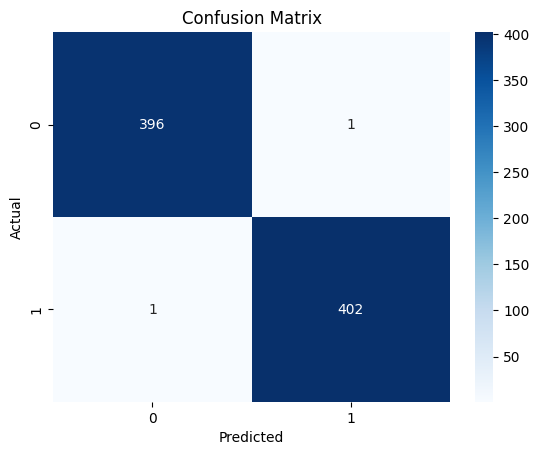

In [9]:
Y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(Y_test, Y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("Accuracy Score:", accuracy_score(Y_test, Y_pred))

# Visualization: Confusion Matrix
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save processed data (Optional)
#processed_data.to_csv("processed_data.csv", index=False)

In [10]:
import pickle

# Save the trained model to a pickle file
pickle_file_path = "model/rf_model.pkl"  # Change the filename as needed
with open(pickle_file_path, 'wb') as file:
    pickle.dump(rf_model, file)

print(f"Model saved as {pickle_file_path}")

Model saved as model/rf_model.pkl


linear svc

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:

from sklearn.svm import LinearSVC

svm_model =LinearSVC()
svm_model.fit(X_train_scaled, Y_train)

LinearSVC()

In [13]:
print("SVM Classification Report:")
svm_predictions = svm_model.predict(X_test_scaled)
print(classification_report(Y_test, svm_predictions))

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       397
           1       1.00      1.00      1.00       403

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



Accuracy Score: 0.99625
Confusion Matrix:


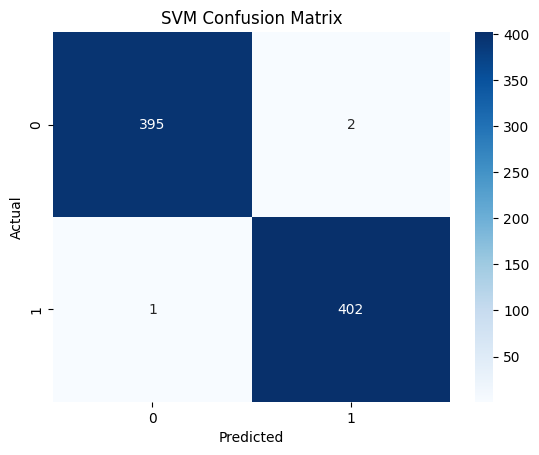

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Accuracy Score:", accuracy_score(Y_test, svm_predictions))

# Confusion Matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(Y_test, svm_predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [15]:
with open('model/svm_model.pkl', 'wb') as file:
    pickle.dump(svm_model, file)


SGM

c:\Users\phani\AppData\Local\Programs\Python\Python310\lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
c:\Users\phani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1186, number of negative: 1214
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10410
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494167 -> initscore=-0.023334
[LightGBM] [Info] Start training from score -0.023334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\phani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


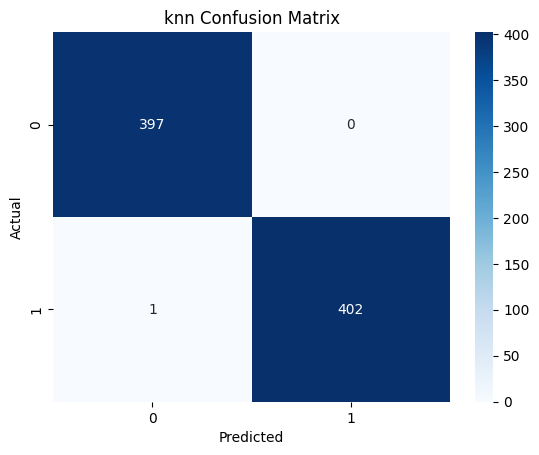

In [16]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train_scaled, Y_train)

print("knn Classification Report:")
lgb_predictions = lgb_model.predict(X_test_scaled)
print(classification_report(Y_test, lgb_predictions))

print("Accuracy Score:", accuracy_score(Y_test, lgb_predictions))

# Confusion Matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(Y_test, lgb_predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("knn Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

with open("model/lgb_model.pkl", "wb") as file:
    pickle.dump(lgb_model, file)

neural network

In [17]:
# from sklearn.preprocessing import LabelEncoder, StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten

# Step 4: Build the CNN Model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),  # Convolutional layer
    MaxPooling1D(pool_size=2),  # Max pooling layer
    Dropout(0.25),  # Prevent overfitting
    Conv1D(filters=64, kernel_size=3, activation='relu'),  # Second convolutional layer
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Flatten(),  # Flatten the 3D output to 1D
    Dense(64, activation='relu'),  # Fully connected layer
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Step 5: Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 6: Train the Model
history = model.fit(X_train_scaled[..., np.newaxis], Y_train, validation_split=0.2, epochs=10, batch_size=64, verbose=1)

# Step 7: Evaluate the Model
loss, accuracy = model.evaluate(X_test_scaled[..., np.newaxis], Y_test, verbose=1)
print(f"Test Accuracy: {accuracy:.2f}")

# Predictions
Y_pred = (model.predict(X_test_scaled[..., np.newaxis]) > 0.5).astype("int32")






Epoch 1/10


30/30 [==============================] - 4s 40ms/step - loss: 0.4041 - accuracy: 0.8250 - val_loss: 0.1571 - val_accuracy: 0.9563
Epoch 2/10
30/30 [==============================] - 0s 16ms/step - loss: 0.1522 - accuracy: 0.9505 - val_loss: 0.0876 - val_accuracy: 0.9667
Epoch 3/10
30/30 [==============================] - 0s 16ms/step - loss: 0.1127 - accuracy: 0.9651 - val_loss: 0.0716 - val_accuracy: 0.9708
Epoch 4/10
30/30 [==============================] - 1s 18ms/step - loss: 0.1032 - accuracy: 0.9693 - val_loss: 0.0641 - val_accuracy: 0.9750
Epoch 5/10
30/30 [==============================] - 0s 16ms/step - loss: 0.0810 - accuracy: 0.9698 - val_loss: 0.0544 - val_accuracy: 0.9771
Epoch 6/10
30/30 [==============================] - 0s 16ms/step - loss: 0.0696 - accuracy: 0.9786 - val_loss: 0.0441 - val_accuracy: 0.9812
Epoch 7/10
30/30 [==============================] - 0s 16ms/step - loss: 0.0649 - accuracy: 0.9771 - val_loss: 0.0454 - val_accuracy: 0.9896
Epoch 8

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       397
           1       1.00      1.00      1.00       403

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



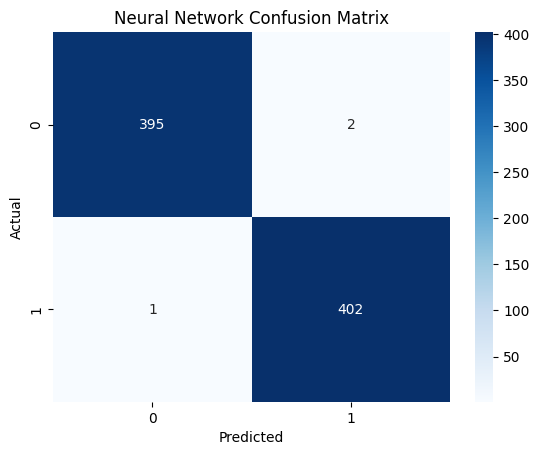

Neural Network Model saved as 'neural_network_model.pkl'.


In [19]:
# Classification Report
print("Classification Report:")
print(classification_report(Y_test, Y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 8: Save the Model as a .pkl File
import pickle
with open("model/neural_network_model.pkl", "wb") as file:
    pickle.dump(model, file)

print("Neural Network Model saved as 'neural_network_model.pkl'.")


KNN

comparision

25/25 [==============================] - 0s 5ms/step


c:\Users\phani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(
c:\Users\phani\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


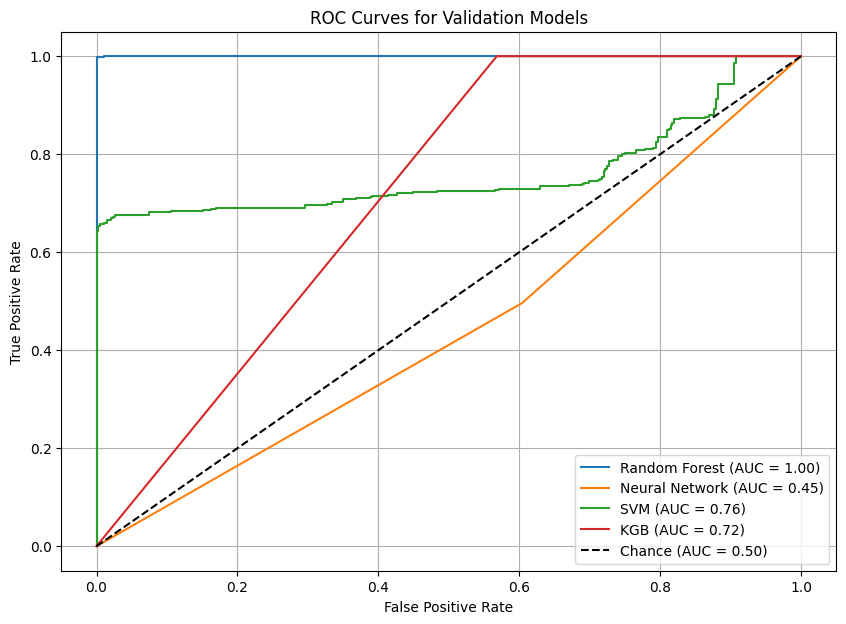

Model Performance:
Random Forest: AUC = 1.00, Accuracy = 1.00
Neural Network: AUC = 0.45, Accuracy = 0.45
SVM: AUC = 0.76, Accuracy = 0.79
KGB: AUC = 0.72, Accuracy = 0.49


In [20]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
import pickle
import matplotlib.pyplot as plt

# Paths to your saved models
model_paths = {
    "Random Forest": "model/rf_model.pkl",
    "Neural Network": "model/neural_network_model.pkl",
    "SVM": "model/svm_model.pkl",
    "KGB": "model/lgb_model.pkl"
}

# Initialize dictionaries to store ROC AUC scores and accuracies
roc_auc_scores = {}
accuracy_scores = {}

# Plot ROC Curve for each model
plt.figure(figsize=(10, 7))
for model_name, model_path in model_paths.items():
    # Load the model
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
    
    # Predict probabilities or scores
    if hasattr(model, "predict_proba"):  # For models with `predict_proba`
        y_probs = model.predict_proba(X_val)[:, 1]
        y_preds = model.predict(X_val)
    elif hasattr(model, "decision_function"):  # For models with `decision_function`
        y_probs = model.decision_function(X_val)
        y_preds = model.predict(X_val)
    else:  # For Sequential models or models with only `predict`
        y_probs = model.predict(X_val).ravel()  # Ensure 1D array
        y_preds = (y_probs > 0.5).astype(int)  # Thresholding for binary classification
    
    # Compute ROC AUC score
    roc_auc = roc_auc_score(Y_val, y_probs)
    roc_auc_scores[model_name] = roc_auc
    
    # Compute accuracy
    accuracy = accuracy_score(Y_val, y_preds)
    accuracy_scores[model_name] = accuracy
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(Y_val, y_probs)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Validation Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Display ROC AUC scores and accuracies
print("Model Performance:")
for model_name in model_paths.keys():
    print(f"{model_name}: AUC = {roc_auc_scores[model_name]:.2f}, Accuracy = {accuracy_scores[model_name]:.2f}")